#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Exploring the TF-Hub CORD-19 Swivel Embeddings

The CORD-19 Swivel text embedding module from TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/2)
 was built to support researchers analyzing natural languages text related to COVID-19.
These embeddings were trained on the titles, authors, abstracts, body texts, and
reference titles of articles in the [CORD-19 dataset](https://pages.semanticscholar.org/coronavirus-research).

In this colab we will:
- Analyze semantically similar words in the embedding space
- Train a classifier on the SciCite dataset using the CORD-19 embeddings


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange
from google.colab import data_table

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Analyze the embeddings

Let's start off by analyzing the embedding by calculating and plotting a correlation matrix between different terms. If the embedding learned to successfully capture the meaning of different words, the embedding vectors of semantically similar words should be close together. Let's take a look at some COVID-19 related terms.

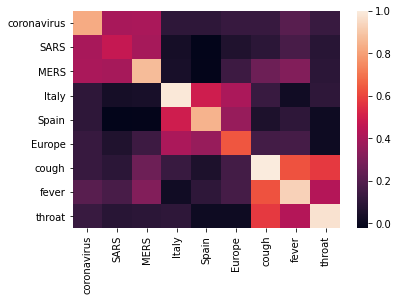

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/2')
embeddings = module(queries)

plot_correlation(queries, embeddings)

We can see that the embedding successfully captured the meaning of the different terms. Each word is similar to the other words of its cluster (i.e. "coronavirus" highly correlates with "SARS" and "MERS"), while they are different from terms of other clusters (i.e. the similarity between "SARS" and "Spain" is close to 0).

Now let's see how we can use these embeddings to solve a specific task.

## SciCite: Citation Intent Classification

This section shows how one can use the embedding for downstream tasks such as text classification. We'll use the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) from TensorFlow Datasets to classify citation intents in academic papers. Given a sentence with a citation from an academic paper, classify whether the main intent of the citation is as background information, use of methods, or comparing results.

In [4]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incompleteKOMPN1/scicite-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incompleteKOMPN1/scicite-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/scicite/1.0.0.incompleteKOMPN1/scicite-test.tfrecord


Dataset scicite downloaded and prepared to /root/tensorflow_datasets/scicite/1.0.0. Subsequent calls will reuse this data.


In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES =   10#@param {type:"integer"}

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))

data_table.DataTable(
    pd.DataFrame({
        TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
        LABEL_NAME: [label2str(x) for x in data[1]]
    }),
    include_index=False)

,string,label
0,The finding that BMI is closely related to TBF...,result
1,The average magnitude of the NBR increases wit...,background
2,It has been reported that NF-κB activation can...,result
3,", 2008; Quraan and Cheyne, 2008; Quraan and Ch...",background
4,"5B), but, interestingly, they shared conserved...",background
5,Some investigators have noted an association o...,background
6,"In our previous study, it is documented that b...",background
7,These subjects have intact cognitive function ...,background
8,Another study reported improved knee function ...,background
9,C. Data Analysis Transcription Speech samples ...,method


## Training a citaton intent classifier

We'll train a classifier on the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) using Keras.  Let's build a model which use the CORD-19 embeddings with a classification layer on top.

In [6]:
#@title Hyperparameters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/2'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[], 
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               8913024   
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 8,913,411
Trainable params: 387
Non-trainable params: 8,913,024
_________________________________________________________________


## Train and evaluate the model

Let's train and evaluate the model to see the performance on the SciCite task

In [7]:
EPOCHS =   35#@param {type: "integer"}
BATCH_SIZE = 32#@param {type: "integer"}

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35
257/257 [==============================] - 1s 4ms/step - loss: 0.9883 - accuracy: 0.5536 - val_loss: 0.9167 - val_accuracy: 0.6594
Epoch 2/35
257/257 [==============================] - 1s 3ms/step - loss: 0.8827 - accuracy: 0.6992 - val_loss: 0.8681 - val_accuracy: 0.7107
Epoch 3/35
257/257 [==============================] - 1s 3ms/step - loss: 0.8535 - accuracy: 0.7257 - val_loss: 0.8477 - val_accuracy: 0.7271
Epoch 4/35
257/257 [==============================] - 1s 3ms/step - loss: 0.8377 - accuracy: 0.7335 - val_loss: 0.8365 - val_accuracy: 0.7325
Epoch 5/35
257/257 [==============================] - 1s 3ms/step - loss: 0.8296 - accuracy: 0.7364 - val_loss: 0.8298 - val_accuracy: 0.7347
Epoch 6/35
257/257 [==============================] - 1s 3ms/step - loss: 0.8257 - accuracy: 0.7390 - val_loss: 0.8241 - val_accuracy: 0.7369
Epoch 7/35
257/257 [==============================] - 1s 3ms/step - loss: 0.8180 - accuracy: 0.7414 - val_loss: 0.8131 - val_accuracy: 0.7533
Epoch 

In [0]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

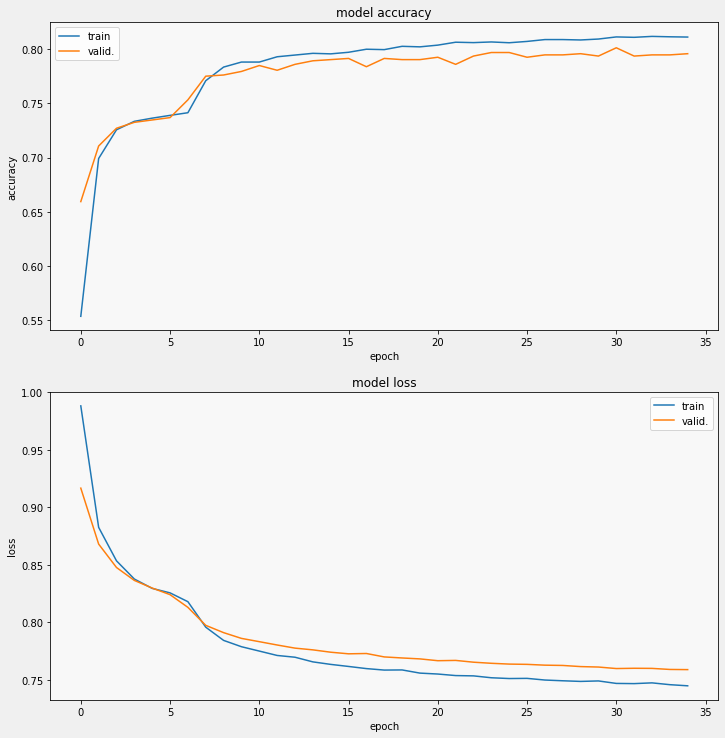

In [9]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.7501 - accuracy: 0.8015
loss: 0.750
accuracy: 0.802


We can see that the loss quickly decreases while especially the accuracy rapidly increases. Let's plot some examples to check how the prediction relates to the true labels:

In [11]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [label2str(x) for x in model.predict_classes(prediction_texts)]

data_table.DataTable(
    pd.DataFrame({
        TEXT_FEATURE_NAME: prediction_texts,
        LABEL_NAME: prediction_labels,
        'prediction': predictions
    }),
    include_index=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,string,label,prediction
0,"The diffraction grating, LED, and split detect...",background,method
1,Our ideas are based on a previous paper [4] de...,background,method
2,Our finding is consistent with the literature ...,result,result
3,Test scores from each of the cognitive domains...,method,method
4,The optimization algorithm was set to maximize...,method,method
5,To quantify the extent of substitution saturat...,method,method
6,Examples of gesture control are based on the e...,method,method
7,The identification of these features has been ...,method,background
8,Postulated mechanisms for observed effects of ...,background,background
9,The right inferior phrenic artery is the most ...,background,background


We can see that for this random sample, the model predicts the correct label most of the times, indicating that it can embed scientific sentences pretty well.

# What's next?

Now that you've gotten to know a bit more about the CORD-19 Swivel embeddings from TF-Hub, we encourage you to participate in the CORD-19 Kaggle competition to contribute to gaining scientific insights from COVID-19 related academic texts.

* Participate in the [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
* Learn more about the [COVID-19 Open Research Dataset (CORD-19)](https://pages.semanticscholar.org/coronavirus-research)
* See documentation and more about the TF-Hub embeddings at https://tfhub.dev/tensorflow/cord-19/swivel-128d/2
* Explore the CORD-19 embedding space with the [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/1/tensorboard/full_projector_config.json)